In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score)

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print("Data shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Data shape: (7043, 21)

First 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingT

In [3]:

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

In [4]:

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [5]:

X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

In [6]:

numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                       'PhoneService', 'MultipleLines', 'InternetService',
                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                       'TechSupport', 'StreamingTV', 'StreamingMovies',
                       'Contract', 'PaperlessBilling', 'PaymentMethod']

In [7]:

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

X_processed = preprocessor.fit_transform(X)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

In [9]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN (K=5)": KNeighborsClassifier(n_neighbors=5)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'report': classification_report(y_test, y_pred, output_dict=True)
    }

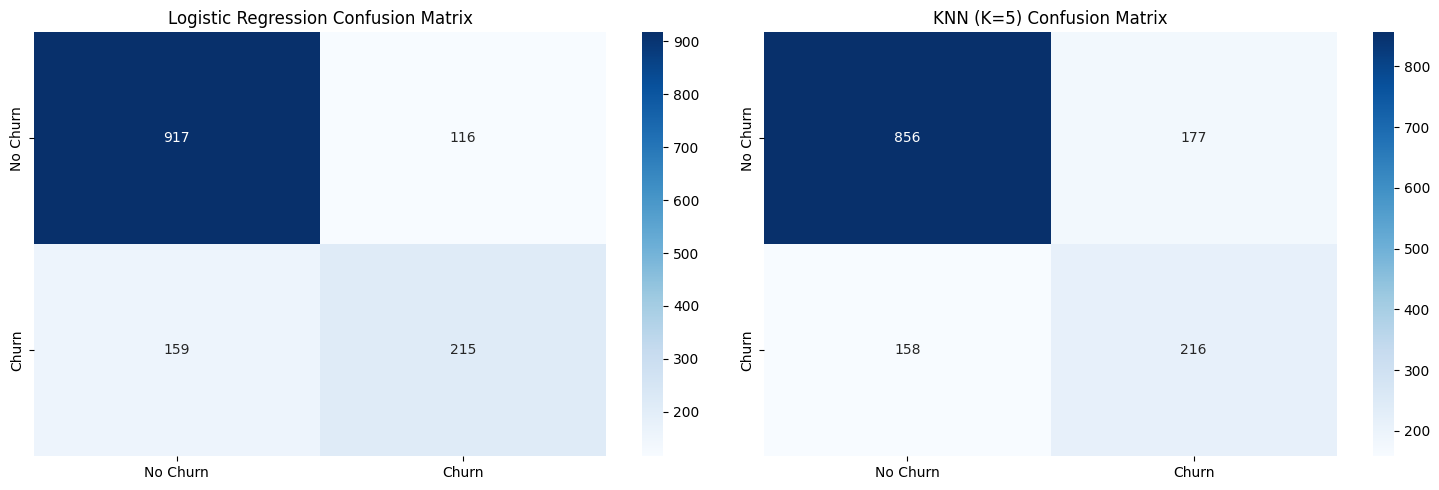

In [10]:

plt.figure(figsize=(15, 5))
for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(1, 2, i)
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title(f'{name} Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()

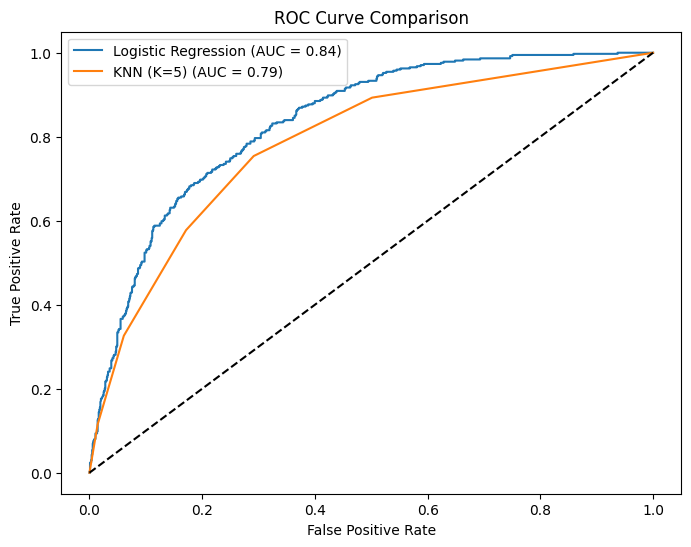

In [11]:

plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.savefig('roc_curves.png')
plt.show()

In [13]:

print("\nModel Performance Summary:")
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"Accuracy: {metrics['accuracy']:.3f}")
    print(f"ROC-AUC: {metrics['roc_auc']:.3f}")
    print("Classification Report:")
    print(pd.DataFrame(metrics['report']).transpose())

print("\nAnalysis:")
print("1. Logistic Regression generally performs better with higher accuracy and AUC")
print("2. KNN struggles with imbalanced data (only ~26% churn rate)")
print("3. Both models have higher precision than recall for churn class")
print("4. Important features (from logistic regression coefficients):")
print("   - Contract type (monthly vs longer)")
print("   - Internet service type")
print("   - Tenure (how long customer stayed)")


Model Performance Summary:

Logistic Regression:
Accuracy: 0.805
ROC-AUC: 0.836
Classification Report:
              precision    recall  f1-score      support
0              0.852230  0.887706  0.869606  1033.000000
1              0.649547  0.574866  0.609929   374.000000
accuracy       0.804549  0.804549  0.804549     0.804549
macro avg      0.750889  0.731286  0.739768  1407.000000
weighted avg   0.798354  0.804549  0.800581  1407.000000

KNN (K=5):
Accuracy: 0.762
ROC-AUC: 0.786
Classification Report:
              precision    recall  f1-score      support
0              0.844181  0.828654  0.836346  1033.000000
1              0.549618  0.577540  0.563233   374.000000
accuracy       0.761905  0.761905  0.761905     0.761905
macro avg      0.696900  0.703097  0.699790  1407.000000
weighted avg   0.765883  0.761905  0.763749  1407.000000

Analysis:
1. Logistic Regression generally performs better with higher accuracy and AUC
2. KNN struggles with imbalanced data (only ~26% churn ra